In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from functools import partial
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np

from auxiliary import *

np.random.seed(123)

# Repeated observations and the estimation of causal effects

**Overview**

* Interrupted time series models

* Regression discontinuity design

* Panel data
    
    * Traditional adjustment strategies
    
    * Model-based approaches

## Interrupted time series models (ITS)

\begin{align*}
Y_t = f(t) + D_t b + e_t
\end{align*}

1. before the treatment is introduced (for $t \le t^*$), $D_t = 0$ and $Y_t = Y^0_t$

2. after the treatment is in place (from $t^*$ through $T$), $D_t = 1$ and $Y_t = Y^1_t$

The causal effect of the treatment is then $\delta_t = Y_t^1 - Y^0_t$ for time periods $t^*$ through $T$. This is equal to $\delta_t = Y_t - Y^0_t$.

<img src="material/figure-11-1.png" height=500 width=500 />

<img src="material/figure-11-2.png" height=500 width=500 />

**Strategies to strengthen ITS analysis**

* Assess the effect of the cause on multiple outcomes that should be be affected by the cause.

* Assess the effect of the cause on outcomes that should not be affected by the cause.

* Assess the effect of the cause withing subgroups across which the causal effect should vary in 
predictable ways.

* Adjust for trends in other variables that may affect or be related to the underlying time series of interest.

* Assess the impact of the termination of th cause in addition to its initiation.


## Regression discontinuity design

We will use the exposition in Froelich & Sperlich (2019) and Angrist & Pischke (2008).

**Example** 

A new education program is designed to give extra funding to schools with larger shares of immigrants $Z$. Assume there is a threshold at $z_0 = 0.25$.  The assignment is that schools with $Z \geq z_0$ receive some additional funding but schools with $Z \leq z_0$ receive nothing. We are interested in the effect of this extra funding $D$ on some student outcomes $Y$.

$\rightarrow$ The basic idea of $RDD$ is to compare the outcomes of schools with $Z$ just below $z_0$ to those with $Z$ just above $z_0$.

How does this setup compare the instrumental variables strategy?



Let's study an example.

\begin{align*}
Y_1 & = 0.5 \times Z + 0.2 \\
Y_0 & = 0.2 \times Z - 0.2
\end{align*}

and 

\begin{align*}
D = \begin{cases}
1 &\text{if}\quad z_0 \geq 0.25 \\
0 &\text{if}\quad z_0 < 0.25 \\
\end{cases}
\end{align*}


* What is the treatment effect at the cutoff?
* What is the average treatment effect?

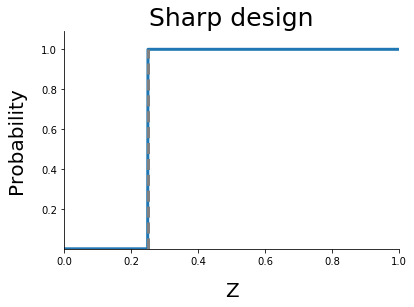

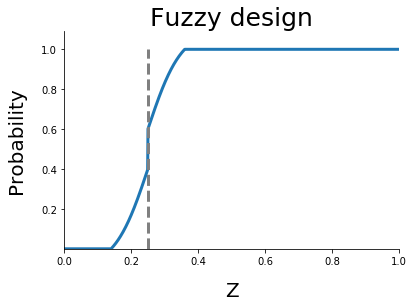

In [11]:
grid = np.linspace(0, 1.0, num=1000)
for version in ['sharp', 'fuzzy']:
    probs = get_treatment_probability(version, grid)
    get_plot_probability(version, grid, probs)

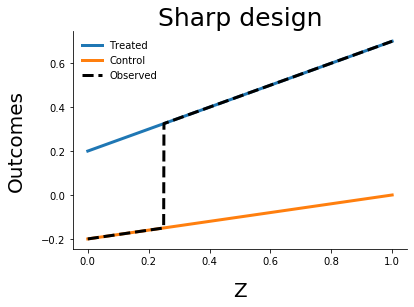

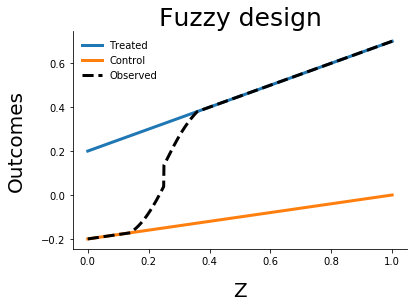

In [12]:
for version in ['sharp', 'fuzzy']:
    plot_outcomes(version, grid)

How does our estimate for the average treatment effect depend on the size of our estimation bin.

In [3]:
df = get_sample_regression_discontinuity()
df.head()

,Y,D,Z
Identifier,,,
0,0.548235,1,0.696469
1,0.34307,1,0.286139
2,-0.15463,0,0.226851
3,0.475657,1,0.551315
4,0.559734,1,0.719469


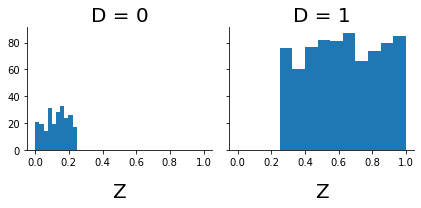

In [14]:
# CODE

One way to estimate the average effect at $z_0$ we need to use observations to the right and left of the cuttoff to compute the treatment and control averages. 

* How does our result depend on the size of the bin?

* What are the alternatives?

In [17]:
def get_average_effect(df, shift):
    """This fucntin compuites the average effect for a given bin size."""'
    control = df['Z'].between(0.25 - shift, 0.25)
    treated = df['Z'].between(0.25, 0.25 + shift)
        
    return df['Y'][treated].mean() - df['Y'][control].mean() 
    
grid = np.linspace(0.01, 0.2)
rslt = list()
for shift in grid:
    rslt.append(get_average_effect(df, shift))

Let's look at the sensitivity of results.

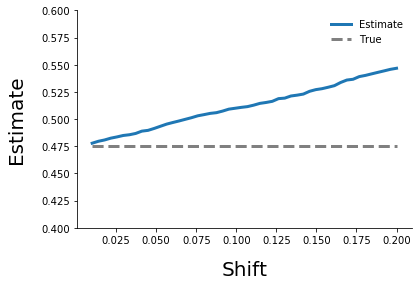

In [16]:
plot_sensitivity_regression_discontinuity(grid, rslt)

Now let's look at some formal derivations for the sharp design.

What about using a parametric model instead?

<img src="material/figure-rdd-misspecification.png" height=500 width=500 />


**Strength and limitations**

* transparent identification

* effect of treatment at particular cutoff $z_0$

* ...

## Panel data



We now need to add a time dimension to our effect analysis, i.e. $Y^d_t$ for $d = 0, 1$.

**Seminal paper**

* Card and Krueger (1994, 2000)

We briefly discuss the exposition from Angrist & Pischke (2007).

<img src="material/fig-card-krueger-1994-1.png" height=500 width=500 />

<img src="material/fig-card-krueger-1994-2.png" height=500 width=500 />

<img src="material/fig-card-krueger-1994-3.png" height=500 width=500 />

**Demonstration** 


\begin{align*}
\text{difference-in-difference} &\qquad Y_{i10} - Y_{i8} = a + D_i^* c + e_i  \\
\end{align*}

<img src="material/figure-11-5.png" height=500 width=500 />

**Control outcomes**

\begin{align*}
Y^0_{i8}  & =  98 + O_i + U_i + X_i + E_i + \nu^0_{i8} \\ 
Y^0_{i9}  & =  99 + O_i + U_i + X_i + E_i + \nu^0_{i9} \\ 
Y^0_{i10} & = 100 + O_i + U_i + X_i + E_i + \nu^0_{i10} \\  
\end{align*}

**Treated outcomes**

\begin{align*}
Y^1_{i9}  & =  Y^0_{i9} + \delta_i^\prime + \delta_i^{\prime\prime}\\ 
Y^1_{i10} & = Y^0_{i10} + (1 + \delta_i^\prime) + \delta_i^{\prime\prime}\\ 
\end{align*}

**Treatment selection**

\begin{align*}
\text{baseline}\qquad  & Pr[D^*_i = 1 \mid O_i, U_i] = \frac{exp(- 3.8 + O_i + U_i)}{1 + exp(- 3.8 + O_i + U_i)} \\
\text{self-selection on gains}\qquad  & Pr[D^*_i = 1 \mid O_i, U_i] = \frac{exp(- 7.3 + O_i + U_i +5 \delta^{\prime\prime})}{1 + exp(- 7.3 + O_i + U_i + 5 \delta^{\prime\prime})} \\
\text{self-selection on pretest}\qquad  & Pr[D^*_i = 1 \mid O_i, U_i] = \frac{exp(- 7.3 + O_i + U_i + k(Y_{i8} - E[Y_{i8}]))}{1 + exp(- 7.3 + O_i + U_i + k(Y_{i8} - E[Y_{i8}]))} 
\end{align*}


Why is the average control outcome higher among the (eventually) treated?

In [2]:
num_agents, selection, trajectory = 1000, 'baseline', 'parallel'
df = get_sample_panel_demonstration(num_agents, selection, trajectory)    
df.groupby(['D_ever', 'Grade'])['Y'].mean()

D_ever  Grade
0       8         97.610416
        9         98.534613
        10        99.599627
1       8        103.518417
        9        104.167154
        10       104.688192
Name: Y_0, dtype: float64

How do our standard estimators perform in these setting?

In [4]:
for selection in ['baseline', 'self-selection on gains', 'self-selection on pretest']:
    for trajectory in ['parallel', 'divergent']:
        print('\n Selection: {:}, Trajectory: {:}'.format(selection, trajectory))
        num_agents, selection, trajectory = 1000, selection, trajectory
        df = get_sample_panel_demonstration(num_agents, selection, trajectory)
        for estimator in ['naive', 'diff']:
            rslt = get_panel_estimates(estimator, df)
            print('{:10}: {:5.3f}'.format(estimator, rslt.params['D']))


 Selection: baseline, Trajectory: parallel
naive     : 14.553
diff      : 9.881

 Selection: baseline, Trajectory: divergent
naive     : 15.727
diff      : 10.956

 Selection: self-selection on gains, Trajectory: parallel
naive     : 13.940
diff      : 11.461

 Selection: self-selection on gains, Trajectory: divergent
naive     : 14.959
diff      : 12.283

 Selection: self-selection on pretest, Trajectory: parallel
naive     : 14.989
diff      : 9.880

 Selection: self-selection on pretest, Trajectory: divergent
naive     : 15.878
diff      : 10.772


<img src="material/table-11-1.png" height=500 width=500 />

## References

* https://www.innovations.harvard.edu/sites/default/files/Braga_problem_oriented%20policing_deterrence.pdf

